In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
import glob
import os
import pandas as pd
import multiprocessing 
from tensorflow.keras.preprocessing import image
import numpy as np
from skimage.filters import threshold_otsu
from skimage.filters import threshold_local
from skimage.filters import gaussian
from skimage.transform import resize
from skimage.filters import sobel, roberts
from skimage import io, color
from skimage.restoration import denoise_bilateral
from skimage.segmentation import slic
from skimage.color import label2rgb
from skimage.feature import canny
from skimage.segmentation import slic
from skimage.color import label2rgb
from skimage import data
import scipy.ndimage as ndi
import gc

In [2]:
def get_file_names(s):
    # retrieves all the filenames in a list of strings
    path = './image_data/PetImages/{}'.format(s)
    vals = []
    for root, dirs, files in os.walk(path):
        for filename in files:
            if os.path.getsize(path + '/'+ filename) == 0:
                continue
            vals.append(filename)
    return sorted(vals)

In [3]:
def display_img(s, filename):
    # Will display any image with the string and filepath provided
    path = './image_data/PetImages/{}/{}'.format(s, filename)
    plt.imshow(mpimg.imread(path))
    plt.show()

In [4]:
cat_filenames = get_file_names('cat')
dogtrain_filenames = get_file_names('dogs_train')
dogtest_filenames = get_file_names('dogs_test')

In [5]:
cat_filenames = cat_filenames[1: len(cat_filenames)]
cat_filenames = cat_filenames[:len(cat_filenames) - 1]

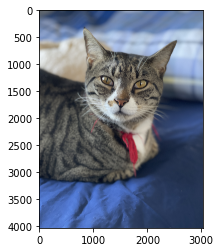

In [6]:
# Passing the name cat and the name of the file will display thte image
display_img('cat', cat_filenames[1])

Every image has either a cat or a dog in them. There are different variations of cats and dogs. Different angles, lighting, and other different features.

In [7]:
print('The number of cat images are: {}'.format(len(cat_filenames)))

The number of cat images are: 12501


In [8]:
def display_image_np(np_array):
    # The functiton takes in an np_array to display the image
    # This will display the image in grayscale
    plt.imshow(np_array, vmin=0, vmax=255, cmap='Greys_r')
    plt.axis('off')
    plt.grid(True)
    plt.show()
    plt.show()

In [9]:
def get_cat_filepath(img_name):
    # Returns the filepath of a given string
    return './image_data/PetImages/cat/{}'.format(img_name)

In [10]:
def get_dog_train_filepath(img_name):
    # Returns the filepath of a given string
    return './image_data/PetImages/dogs_train/{}'.format(img_name)

In [11]:
def get_dog_test_filepath(img_name):
    # Returns the filepath of a given string
    return './image_data/PetImages/dogs_test/{}'.format(img_name)

In [12]:
# First thing to check is to see how the images' pixels average values look
def tonp(func, list_of_images, size=(500, 500)):
    # for img in list_of_images:
    path = func(list_of_images)
    # Transforming all the images to size 400x400
    current_img = image.load_img(path, target_size=size, color_mode='grayscale')
    # makes a matrix
    img_ts = image.img_to_array(current_img)
    # converts to a vector
    img_ts = [img_ts.ravel()]
    current_img.close()
    try:
        # Brings all the new vectors into one giant array
        full_mat = np.concatenate((full_mat, img_ts))
    except UnboundLocalError:
        full_mat = img_ts
    return full_mat

In [13]:
def get_mean_img(data):
    
    # Creates a multiprocessing pool to speed up iteration
    a_pool = multiprocessing.Pool()
    # returns a list of numpy array with the values of pixels for each image
    result = a_pool.map(tonp, data)
    # Returns the mean of each image in a (1, 90,000) vector
    res = np.mean(result, axis=0)
    # reshape the image back into a matrix
    mean_img = np.array(res).reshape((500,500))
    # Displays what the average image looks like
    display_image(mean_img)
    return mean_img

# Transformations made to the data

Grayscaling was done to the data 

In [14]:
def turn_gray(np_matrix):
    # Converts the np_matrix into a grayscale image
    return color.rgb2gray(np_matrix)

In [15]:
def wrapper_to_grayscale(args):
    return to_grayscale(*args)

In [16]:
def to_grayscale(func, data):
    # takes an image string name and then converts it into an np vector
    # Takes in the string name and a function argument
    sample_cat = tonp(func, data) 
    # takes the sample cat and then reshapes it into a 500x500 matrix
    grayscale_cat = turn_gray(sample_cat[0].reshape((500,500)))
    # Displays the iamges using the display_image fucntion
    display_image_np(grayscale_cat)
    return grayscale_cat

In [17]:
def get_transformed_image(np_array):
    im = np_array.reshape(500, 500).astype('uint')
    hist = ndi.histogram(im, min=0, max=255, bins=256)
    # Create a cumulative distribution function
    cdf = hist.cumsum() / hist.sum()
    im_equalized = cdf[im] * 255
#     This will provide the graphs  
#     tr = get_transformed_image(im_equalized)
#     fig = plt.figure(figsize=(10, 10))
#     ax1 = fig.add_subplot(221, xlabel='# Of pixels', ylabel='# Of pixels', title='Transformed Image')
#     ax1.imshow(dogtest_transformed_images[1])
#     ax2 = fig.add_subplot(222,  sharex=ax1, sharey=ax1, xlabel='# Of pixels', title='Original Image')
#     ax2.imshow(tr)
#     plt.show()
    # Transforming the image by removing the noise and preserving the edges
#     denoised_image = ndi.gaussian_filter(im_equalized, sigma=3)
    denoised_image = denoise_bilateral(im_equalized, multichannel=False)
    del im_equalized
    gc.collect()
    # Sobel is used here to be able to detect the edges of the image
    sob = sobel(denoised_image)
    return sob

In [18]:
cat_iterators = []
for cat in range(len(cat_filenames)):
    cat_iterators.append((get_cat_filepath, cat_filenames[cat]))

In [20]:
dogtrain_iterators = []
for dog in dogtrain_filenames:
    dogtrain_iterators.append((get_dog_train_filepath, dog))
dogtest_iterators = []
for dog in dogtest_filenames:
    dogtest_iterators.append((get_dog_test_filepath, dog))

In [21]:
# multiprocessing to speed up the program
a_mult = multiprocessing.Pool()
# maps each iterated value onto the function to_grayscale
cat_img = a_mult.map(wrapper_to_grayscale, cat_iterators)

In [22]:
gc.collect()
cat_transformed_images = a_mult.map(get_transformed_image, cat_img)

In [23]:
del cat_img
gc.collect()

20

In [24]:
dog_train = a_mult.map(wrapper_to_grayscale, dogtrain_iterators)

In [25]:
gc.collect()
dogtrain_transformed_images = a_mult.map(get_transformed_image, dog_train)

In [26]:
del dog_train
gc.collect()

20

In [27]:
dog_test = a_mult.map(wrapper_to_grayscale, dogtest_iterators)

In [28]:
gc.collect()
dogtest_transformed_images = a_mult.map(get_transformed_image, dog_test)

In [29]:
del dog_test
gc.collect()

20

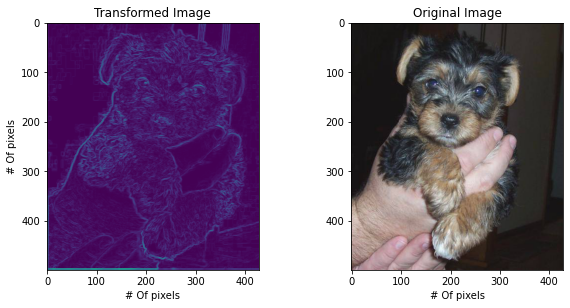

In [30]:
img_num = 1
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(221, xlabel='# Of pixels', ylabel='# Of pixels', title='Transformed Image')
ax1.imshow(dogtest_transformed_images[img_num])
ax2 = fig.add_subplot(222,  sharex=ax1, sharey=ax1, xlabel='# Of pixels', title='Original Image')
ax2.imshow(mpimg.imread(get_dog_test_filepath(dogtest_filenames[img_num])))
plt.show()

#### Exploratory Data Analysis

In [31]:
# The EDA can begin by checking the variance of the images
cat_var_all = ndi.variance(cat_transformed_images[0])
cat_var_all

28.23778764228002

In [32]:
dogtrain_var_all = ndi.variance(dogtrain_transformed_images[0])
dogtrain_var_all

222.43248089142799

In [33]:
dogtest_var_all = ndi.variance(dogtest_transformed_images[0])
dogtest_var_all

196.6378542148171

In [34]:
# do stats on labels
len_cat_images = len(cat_transformed_images)
len_dog_images = len(dogtrain_transformed_images) + len(dogtest_transformed_images)

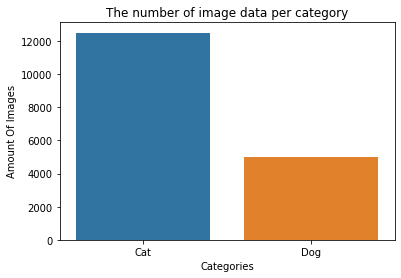

In [35]:
sns.barplot(x=['Cat', 'Dog'], y=[len_cat_images, len_dog_images])
plt.xlabel('Categories')
plt.ylabel('Amount Of Images')
plt.title('The number of image data per category')
plt.show()

PCA for the images

In [36]:
cat_vector = []
sample_length = len(cat_transformed_images) - (len(cat_transformed_images) - 100)
for i in range(sample_length):
    cat_vector.append(cat_transformed_images[i].ravel())
cat_vector

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 

In [37]:
dogtrain_vector = []
sample_length = len(dogtrain_transformed_images) - (len(dogtrain_transformed_images) - 100)
for i in range(sample_length):
    dogtrain_vector.append(dogtrain_transformed_images[i].ravel())
dogtrain_vector

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 

In [38]:
dogtest_vector = []
sample_length = len(dogtest_transformed_images) - (len(dogtest_transformed_images) - 100)
for i in range(sample_length):
    dogtest_vector.append(dogtest_transformed_images[i].ravel())
dogtest_vector

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 

In [39]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(cat_vector)
cat_pca = pca.transform(cat_vector)

In [40]:
dogtrain_pca = pca.transform(dogtrain_vector)

In [41]:
dogtest_pca = pca.transform(dogtest_vector)

In [42]:
cat_df = pd.DataFrame(cat_pca).join(pd.DataFrame({'y': [1] * 100}))
dogtrain_df = pd.DataFrame(dogtrain_pca).join(pd.DataFrame({'y': [0] * 100}))
dogtest_df = pd.DataFrame(dogtest_pca).join(pd.DataFrame({'y': [0] * 100}))
final_df = cat_df.append([dogtrain_df, dogtest_df])
final_df = final_df.reset_index(drop=True)
final_df.tail()

,0,1,2,3,4,5,6,7,8,9,y
295,2904.879592,-1526.353694,-95.373146,-620.368008,-841.443552,-630.515795,-23.521703,0.356486,96.400507,-123.411122,0
296,2677.211109,-1115.073540,-1333.581756,586.130376,116.515797,659.883408,-781.370865,159.171111,-324.322133,16.983473,0
297,737.322235,137.852892,-768.952154,337.727048,188.289289,756.028156,-630.046188,-191.940574,-25.599028,-331.488566,0
298,939.912937,-1292.771689,286.209916,-109.475285,-91.959734,-301.076726,234.721080,410.586815,-79.525225,-180.916853,0
299,602.261689,-226.396660,-267.680031,359.507550,413.018000,233.306135,-200.983451,-468.448754,-470.636552,-348.120657,0


In [43]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [44]:
X = final_df.drop('y', axis=1)
y = final_df['y']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [46]:
logreg = SVC()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [47]:
f1_score(y_pred, y_test)

0.7272727272727272

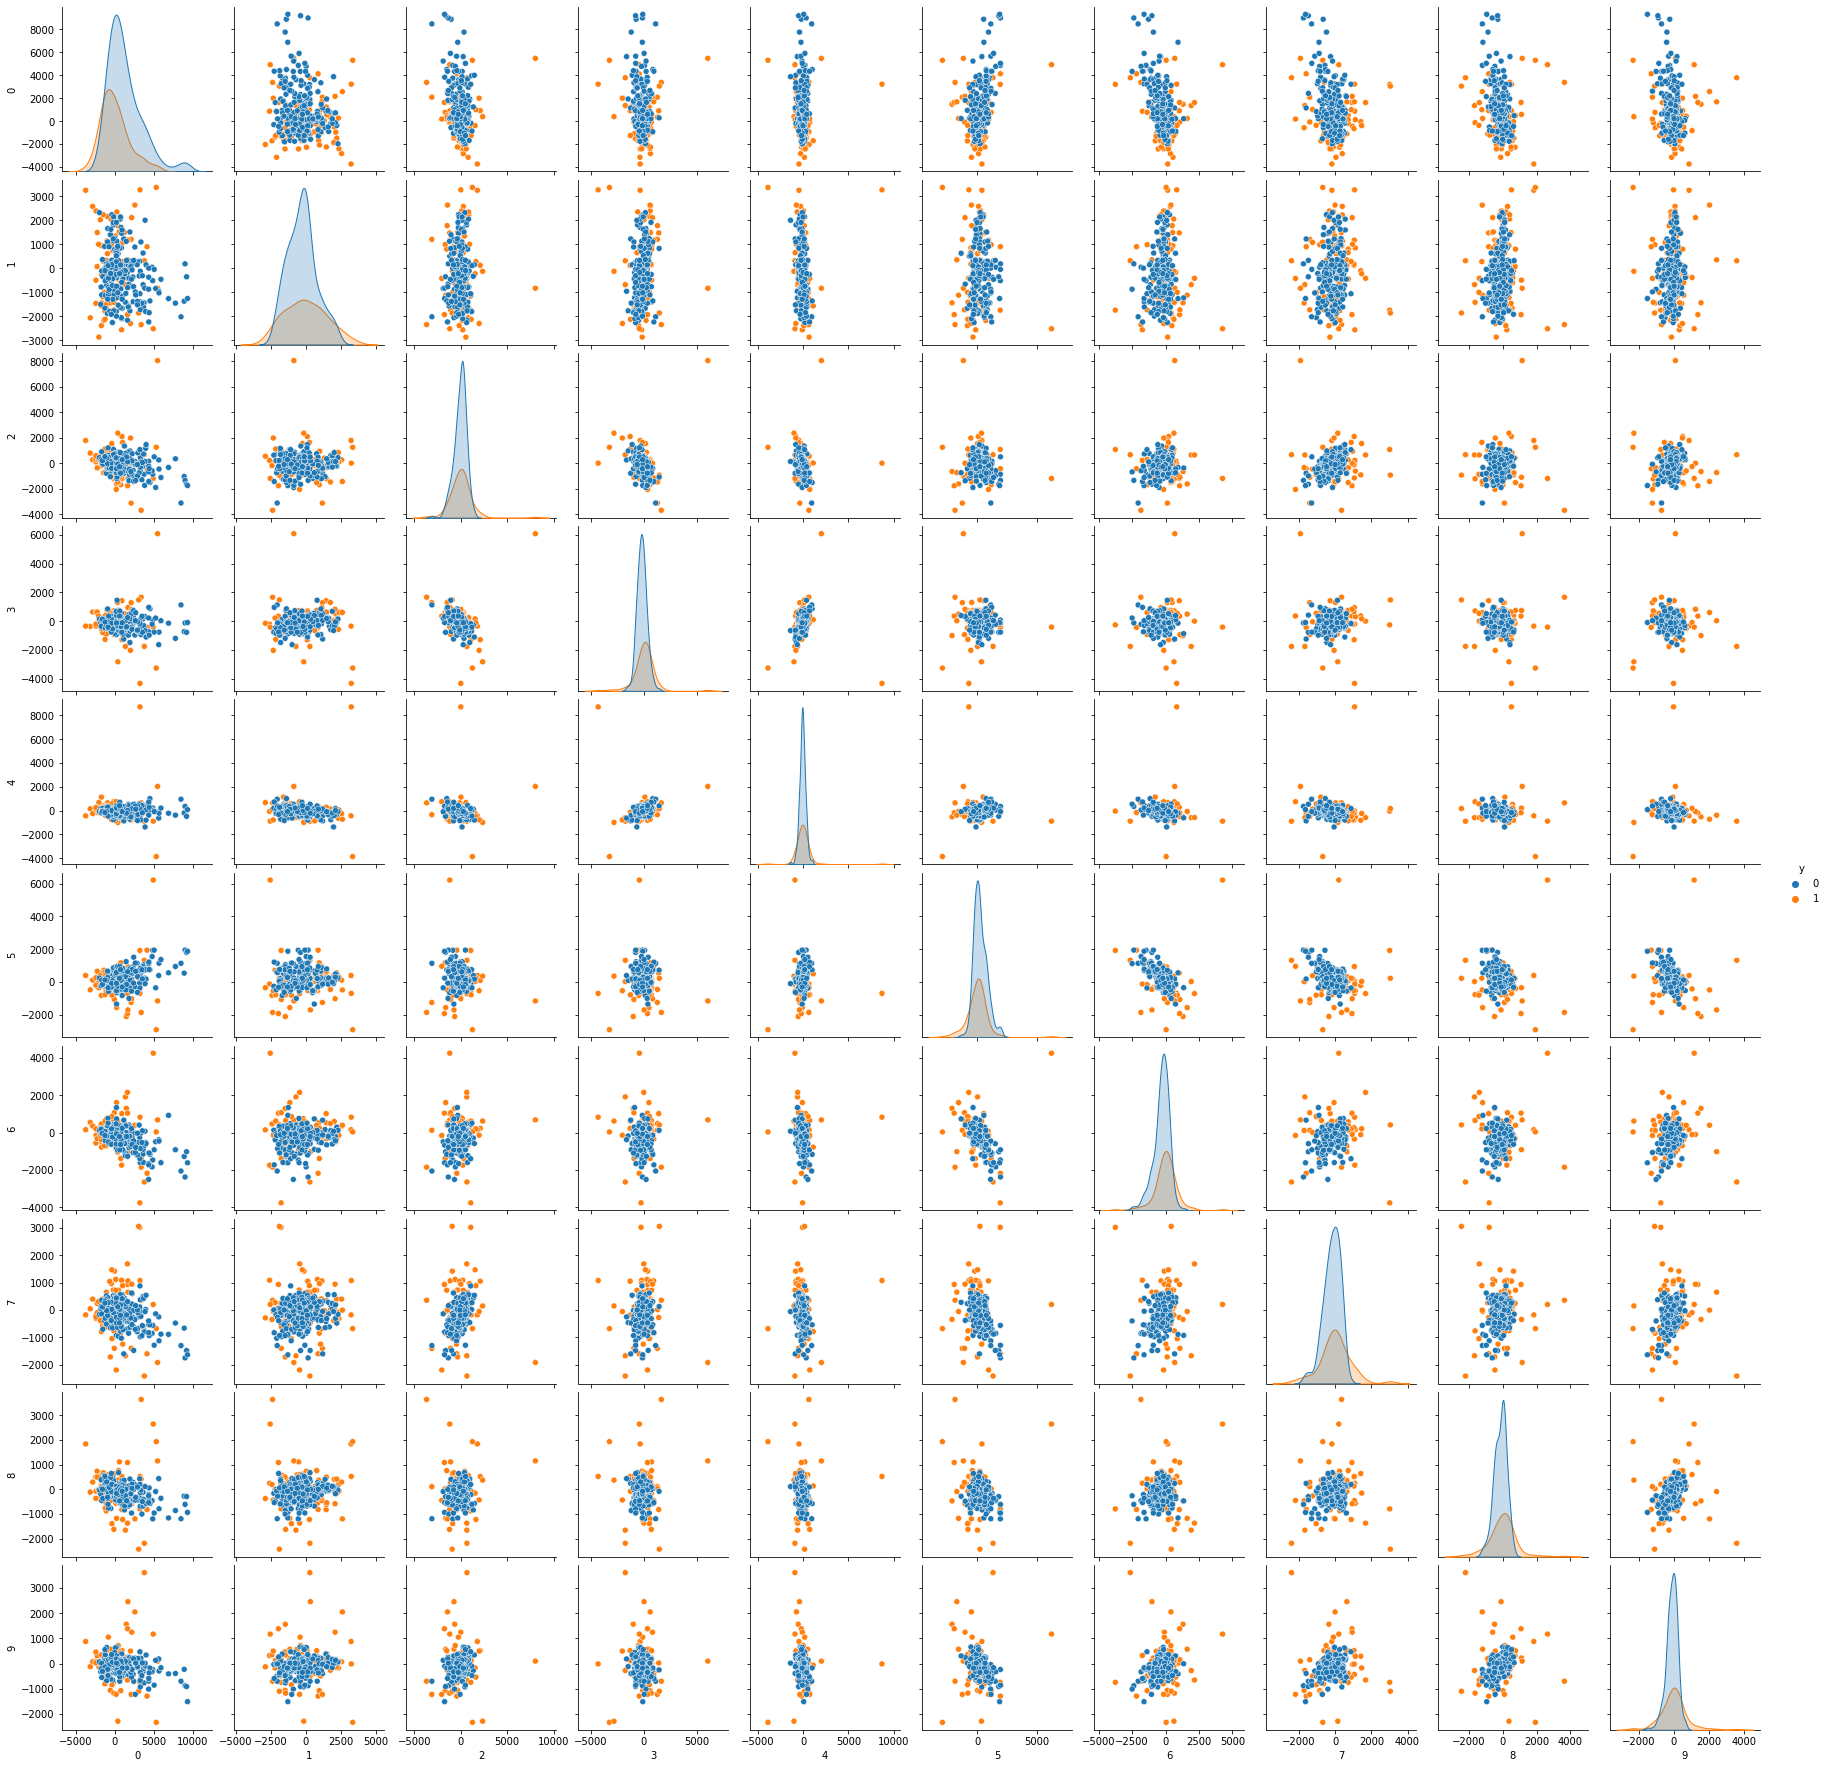

In [48]:
sns.pairplot(final_df, hue='y')
plt.show()

In [49]:
# Transfer transformed images to new file
cat_transformed_images[0]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 67.79147095, 32.06253967, ...,  3.88468221,
         8.85919858,  0.        ],
       [ 0.        , 67.79167718, 32.06282037, ...,  3.92496629,
         8.94251485,  0.        ],
       ...,
       [ 0.        , 66.44990473, 75.08057084, ...,  0.08245409,
         0.08097392,  0.        ],
       [ 0.        , 54.66914701, 72.16690058, ...,  0.08195662,
         0.08056594,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [50]:
def to_folder(foldername, array, i):
    data = array.astype(np.uint8)
    data = Image.fromarray(data)
    data.save('/Users/albertolopez/SpringboardCapstone3/transformed_images/{}/{}.png'.format(foldername, i))

In [51]:
for i in range(len(cat_transformed_images)):
    to_folder('Cat', cat_transformed_images[i], i)

In [52]:
for i in range(len(dogtrain_transformed_images)):
    to_folder('DogTrain', dogtrain_transformed_images[i], i)

In [53]:
for i in range(len(dogtest_transformed_images)):
    to_folder('DogTest', dogtest_transformed_images[i], i)